# See how sensitive the prediction at s[51] is on Y[50]

In [2]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import time
# Library for Gaussian process
import GPy

/Users/liy0h/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def create_mlp(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim = feature_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

In [4]:
def calculate_phi(N):
    num_basis = [10,19,37,73]
    knots = [np.linspace(0,1,i) for i in num_basis]
    ##Wendland kernel
    K = 0 ## basis size
    phi = np.zeros((N, sum(num_basis)))
    for res in range(len(num_basis)):
        theta = 1/num_basis[res]*2.5
        for i in range(num_basis[res]):
            d = np.absolute(s-knots[res][i])/theta
            for j in range(len(d)):
                if d[j] >= 0 and d[j] <= 1:
                    phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
                else:
                    phi[j,i + K] = 0
        K = K + num_basis[res]
    return phi

In [ ]:
time_elapsed = np.zeros(8)
time_elapsed2 = np.zeros(8)
for i in range(8):
    # Generate a dataset
    N = 100*(2**i)
    s = np.linspace(0,1,N).reshape(-1,1)
    Y = 10 * np.cos(20 * s)
    Y[Y<0] = 0
    K=10+19+37+73
    np.random.seed(1)
    Z = np.random.normal(Y,1, size=(N,1))
    model = create_mlp(feature_dim = K)
    phi = calculate_phi(N)
    time_start = time.clock()
    model.fit(phi,Z, validation_split = 0, epochs = 200, batch_size = 32, verbose = 0)
    time_elapsed[i] = (time.clock() - time_start)
    kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
    m = GPy.models.GPRegression(s, Z, kernel)
    time_start_2 = time.clock()
    m.optimize(max_iters=200)
    time_elapsed2[i] = (time.clock() - time_start_2)
    print(f"DeepKriging training time when N={N}:{time_elapsed}")
    print(f"Kriging training time when N={N}:{time_elapsed2}")

DeepKriging training time when N=100:[3.698477 0.       0.       0.       0.       0.       0.       0.      ]
Kriging training time when N=100:[0.178112 0.       0.       0.       0.       0.       0.       0.      ]
DeepKriging training time when N=200:[3.698477 5.460127 0.       0.       0.       0.       0.       0.      ]
Kriging training time when N=200:[0.178112 0.375426 0.       0.       0.       0.       0.       0.      ]
DeepKriging training time when N=400:[3.698477 5.460127 9.227419 0.       0.       0.       0.       0.      ]
Kriging training time when N=400:[0.178112 0.375426 1.139838 0.       0.       0.       0.       0.      ]
DeepKriging training time when N=800:[ 3.698477  5.460127  9.227419 19.393113  0.        0.        0.
  0.      ]
Kriging training time when N=800:[0.178112 0.375426 1.139838 7.456006 0.       0.       0.       0.      ]
DeepKriging training time when N=1600:[ 3.698477  5.460127  9.227419 19.393113 33.324421  0.        0.
  0.      ]
Kriging tr

In [30]:
time_DK_gpu = np.array([ 2.281631,  2.825783,  4.611376,  7.580814, 12.966882, 23.318432,
       48.726707, 94.000705])
time_DK_cpu = np.array([3.698477,   5.460127,  9.227419,  19.393113,  33.324421,  65.716591,
 130.754029,   214.286753])
time_UK = np.array([1.78112000e-01, 3.75426000e-01, 1.13983800, 7.45600600,
 46.0366860, 151.993857, 867.024742, 5663.8260709999995])

In [9]:
##Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

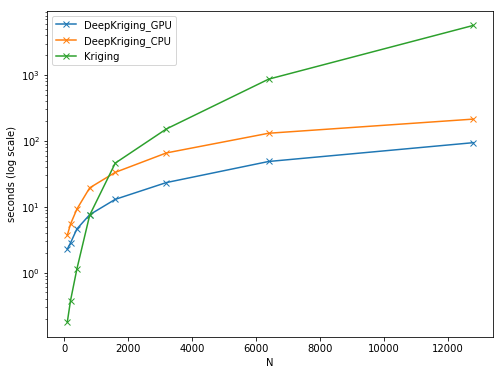

In [32]:
N = 100 * 2**np.arange(0, 8)
pylab.plot(N, time_DK_gpu,"x-",label="DeepKriging_GPU")
pylab.plot(N, time_DK_cpu,"x-",label="DeepKriging_CPU")
pylab.plot(N, time_UK,"x-",label="Kriging")
pylab.legend(loc='upper left')
pylab.yscale("log")
pylab.xlabel("N")
pylab.ylabel("seconds (log scale)")
#pylab.show()
plt.savefig("runtime.pdf")

In [18]:
N

array([  100,   200,   400,   800,  1600,  3200,  6400, 12800])